In [ ]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import os
import time
from imagePreprocess import getImagesVarAndMean

In [ ]:
# TODO:
# find how to use multithreading in jupyter on windows
# less green
%load_ext blackcellmagic
dataDir = "data/resized/"
biggerNet = True
depthMultiplier = 1
initializer = 'glorot_uniform' #'he_normal'#

In [108]:
def showHsv(img):    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

def customLoss(yTrue, yPred):
    # cyclic loss
    hueTrue = yTrue[...,0]
    huePred = yPred[...,0]
    maxHue = 180
    hue = K.square(huePred - hueTrue) 
    
#     hue2 = K.minimum(K.square(huePred - hueTrue), 
#                     K.minimum(K.square(huePred - hueTrue + maxHue), 
#                               K.square(huePred - hueTrue - maxHue)))
    #hue = K.minimum((huePred + 181 - hueTrue) % 181, (hueTrue + 181 - huePred) % 181) #3
    #hue = K.square( (huePred - hueTrue) % 181 )
    satDiff = yPred[...,1] - yTrue[...,1]
    # double loss for undershooting saturation
    # if sign is + then mul is 2, if sign is - mul is 2
    mul1or2 = (-K.sign(satDiff) +1)*2 + 1 # was /2
    saturation =  mul1or2*K.square(satDiff)
    #saturation = K.square(satDiff)
    #hue = hue  + 1 / (huePred + 1)
    #hue2 = hue2  + 1 / (huePred + 1)
    return K.concatenate([hue, saturation], axis=-1) # predictedHue was 0 when order is reversed

In [109]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
img_in = cv2.imread('pic.jpg')
# maybe should switch to LAB colorspace?
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255
(1008, 1600, 3)


In [110]:
def loadImgHsv(path):
    '''
    returns X - value
            Y - (hue, saturation)
    '''
    img_in = cv2.imread(path)
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, var, mean, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.hsstd = np.sqrt(var[...,:2])
        self.hsmean = mean[...,:2]
        self.vstd = np.sqrt(var[...,2])
        self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd # it doesn't like standardization 
        X = np.expand_dims(X, axis=len(X.shape))
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [111]:
params = {'dim': (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 2,
          'shuffle': True}
data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSplitPercent = 0.1
trainSize = int(len(data_IDs)*trainSplitPercent)
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSplitPercent = 0.02
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))


training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape)
print(params['mean'].shape)

dataset size 202599
train len 20259
val len 4051
(32, 128, 128, 2)
(128, 128, 3)


In [112]:
def createModel(input_shape, bigger, mul, initializer):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(inputs)
    if bigger:
        conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(pool1)
    if bigger:
        conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(pool2)
    if bigger:
        conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(pool3)
    if bigger:
        conv4 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv4)
    
    up5 = Conv2D(64*mul, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(merge5)
    if bigger:
        conv5 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv5)
    
    up6 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(merge6)
    if bigger:
        conv6 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv6)
    
    up7 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(merge7)
    #if bigger:
    conv7 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv7)
    # todo change to sigmoid?
    # Stride 1 deconvolutions — which we often see as the last layer in successful models 
    conv7 = Conv2D(2, 1, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv7)
    
    model = Model(inputs=inputs, outputs=conv7)
    
    model.compile(loss=customLoss,#'mean_squared_error',#customLoss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'], biggerNet, depthMultiplier, initializer)
model.summary()
print(model.output_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_513 (Conv2D)             (None, 128, 128, 16) 160         input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_514 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_513[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_81 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_514[0][0]                 
__________________________________________________________________________________________________
conv2d_515

In [113]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet', 'bigger' if biggerNet else 'smaller', f'mul{depthMultiplier}', initializer]
NAME = "_".join(str(l) for l in layers) + f"{ currTime }"
print(NAME)
model = createModel(params['dim'], biggerNet, depthMultiplier, initializer)
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
countEpochs = 1
#Compiling a model does not modify its state. Weights after compilation are the same as before compilation.

unet_bigger_mul1_glorot_uniform13-05-2019-03-01-11
Epoch 1/1
633/633 [==============================] - 99s 156ms/step - loss: 6365.1762 - mean_absolute_error: 50.4128 - mean_squared_error: 4281.2894 - val_loss: 4870.1798 - val_mean_absolute_error: 50.1955 - val_mean_squared_error: 3982.3366


In [83]:
# model.load_weights('data/unet_bigger_mul1_glorot_uniform13-05-2019-00-47-35.h5')
# countEpochs = 1

Epoch 2/2
633/633 [==============================] - 95s 150ms/step - loss: 4679.1422 - mean_absolute_error: 45.7234 - mean_squared_error: 3463.1036 - val_loss: 4380.3826 - val_mean_absolute_error: 42.7572 - val_mean_squared_error: 3052.7058
predy 4.909317 245.67366 81.32915 (1, 128, 128, 2)
hue: 4.909317 97.06678 38.019146
sat: 45.91156 245.67366 124.639145
predy uint8 4 245 80.82785034179688
hue uint8 4 97 37.5164794921875


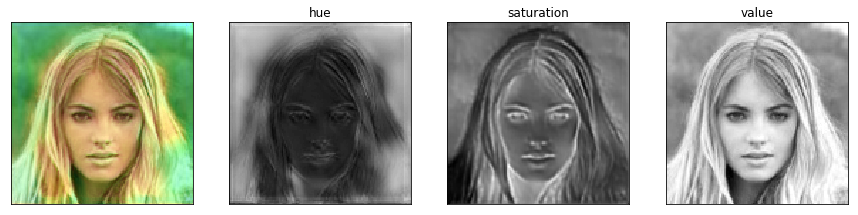

Epoch 3/3
633/633 [==============================] - 94s 149ms/step - loss: 4403.4631 - mean_absolute_error: 43.6451 - mean_squared_error: 3264.6794 - val_loss: 4199.6776 - val_mean_absolute_error: 42.7792 - val_mean_squared_error: 2994.1313
predy 0.0 305.40475 100.154305 (1, 128, 128, 2)
hue: 0.0 96.203354 43.91061
sat: 31.084267 305.40475 156.39801
predy uint8 0 255 99.61721801757812
hue uint8 0 96 43.412353515625


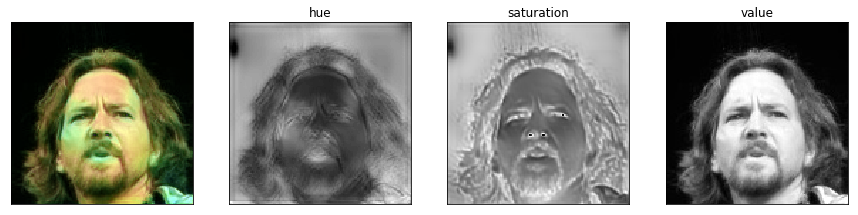

In [115]:
for i in range(1,3):
    #start_time = time.time()
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    initial_epoch=countEpochs, # for tensorflow graph continuation
                    epochs=countEpochs+1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    countEpochs+=1
    #elapsed_time = time.time() - start_time
    #print(f"epochs:{countEpochs}, elapsed time:{elapsed_time}")
    predictFromImage(f'data/resized/{i+18:06}.jpg', True)

In [16]:
def showImgFromPredict(hs, v, showDetails=False):
    '''shows h/s/v and complete image
    hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    hs, v = hs[0], v[0,...,0]
#     print('hs:',hs.shape)
    h, s = hs[...,0], hs[...,1]
    #print('h',h.shape,'s',s.shape,'v',v.shape)
    #print(h.dtype, s.dtype, v.dtype)
    hsv = cv2.merge([h,s,v])
    # showHsv(hsv)    
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
    
    f, axarr = plt.subplots(1,4, figsize=(15,15))
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(img)
    for i in range(2,-1,-1):
        pic = hsv[:,:,i]
        #axarr.title(['hue', 'saturation', 'value'][i])
        axarr[1+i].title.set_text(['hue', 'saturation', 'value'][i])
        axarr[1+i].set_xticks([])
        axarr[1+i].set_yticks([])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()
    
def predictFromImage(img, showDetails=False):
    '''processes input img, makes prediction from its value,
    and shows resulting image, hue, saturation and value'''
    X, Y = validation_generator[1]
    #print('xshape',X.shape, 'yshape',Y.shape)

    inX, inY = loadImgHsv(img )
    inX, inY = inX[None,...,None], inY[None,:]
    X, Y = X[10][None,:], Y[0][None,:]

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)

    print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
    print('hue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
    print('sat:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
    predY[...,0] = predY[...,0] % 181
    predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    print('predy uint8',predY.min(), predY.max(), predY.mean() )
    hue = predY[...,0]
    print('hue uint8',hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)
    
def predictions(start=trainSize+98, count=10):
    '''display count predictionst, beginning from start'''
    for i in range(start,start+count):
        predictFromImage(f'data/resized/{i:06}.jpg', True)

countEpochs 1
predy 2.0610983 242.49632 93.51462 (1, 128, 128, 2)
hue: 2.0610983 94.7204 41.7342
sat: 52.340885 242.49632 145.29504
predy uint8 2 242 93.0142822265625
hue uint8 2 94 41.234619140625


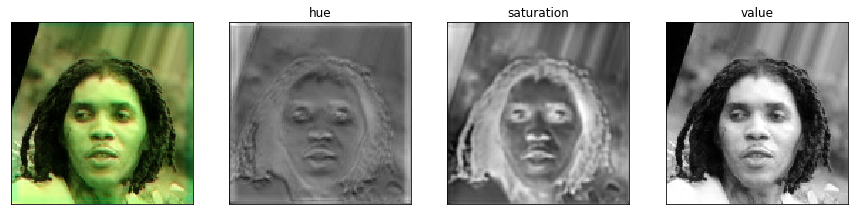

predy 3.1508512 221.73604 78.49405 (1, 128, 128, 2)
hue: 3.1508512 73.934364 38.309544
sat: 57.60356 221.73604 118.67854
predy uint8 3 221 77.99417114257812
hue uint8 3 73 37.80853271484375


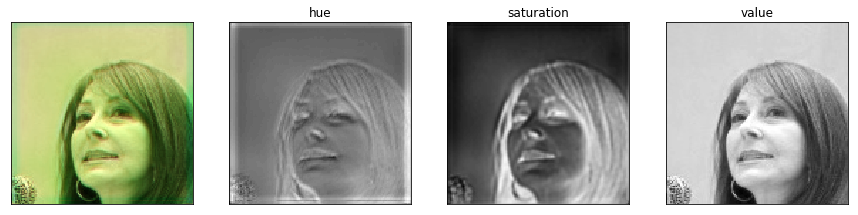

predy 4.5591583 249.79414 85.60805 (1, 128, 128, 2)
hue: 4.5591583 100.02125 40.821884
sat: 53.086838 249.79414 130.39423
predy uint8 4 249 85.10714721679688
hue uint8 4 100 40.3228759765625


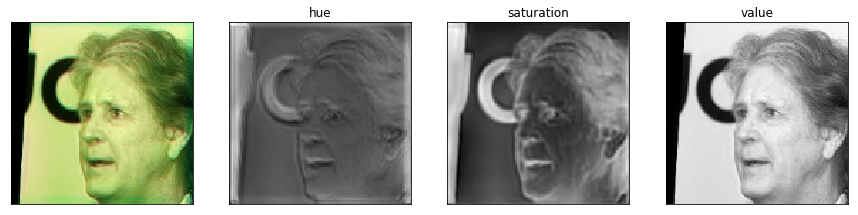

predy 1.7616498 221.45126 84.03907 (1, 128, 128, 2)
hue: 1.7616498 70.79439 39.66224
sat: 47.441547 221.45126 128.4159
predy uint8 1 221 83.537353515625
hue uint8 1 70 39.15679931640625


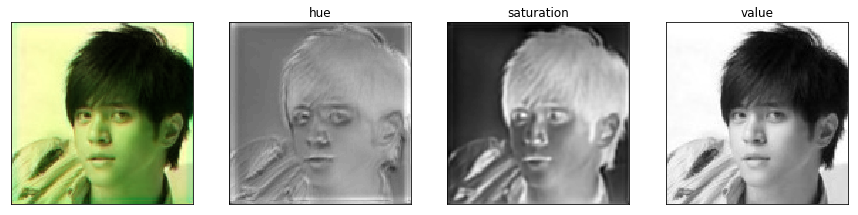

predy 2.7010064 242.01776 97.823975 (1, 128, 128, 2)
hue: 2.7010064 84.70154 44.02588
sat: 73.29026 242.01776 151.62207
predy uint8 2 242 97.3251953125
hue uint8 2 84 43.5283203125


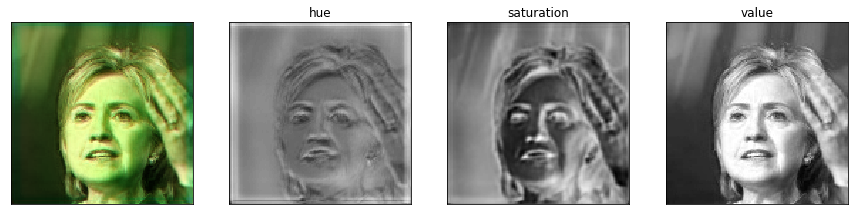

predy 2.6104813 217.21945 81.186775 (1, 128, 128, 2)
hue: 2.6104813 71.4681 37.347
sat: 64.0189 217.21945 125.02654
predy uint8 2 217 80.68771362304688
hue uint8 2 71 36.848876953125


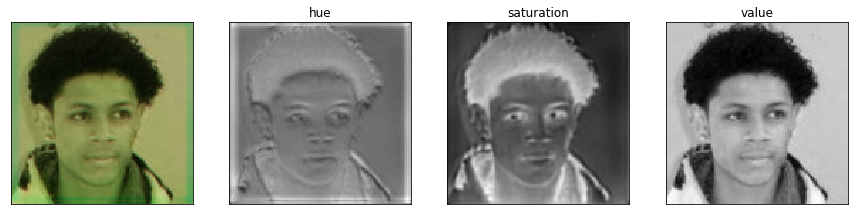

predy 4.329352 230.09932 89.883484 (1, 128, 128, 2)
hue: 4.329352 79.89364 40.939434
sat: 56.328186 230.09932 138.82755
predy uint8 4 230 89.38626098632812
hue uint8 4 79 40.44281005859375


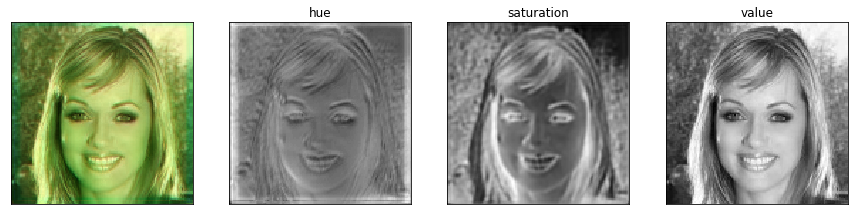

predy 2.0310085 213.06256 95.93947 (1, 128, 128, 2)
hue: 2.0310085 96.216675 43.7402
sat: 67.81489 213.06256 148.13873
predy uint8 2 213 95.43893432617188
hue uint8 2 96 43.2408447265625


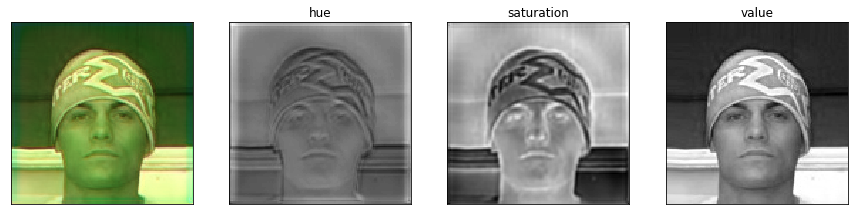

predy 1.8122272 264.11618 86.52133 (1, 128, 128, 2)
hue: 1.8122272 87.45996 40.84346
sat: 63.671825 264.11618 132.19919
predy uint8 0 255 85.91015625
hue uint8 1 87 40.34375


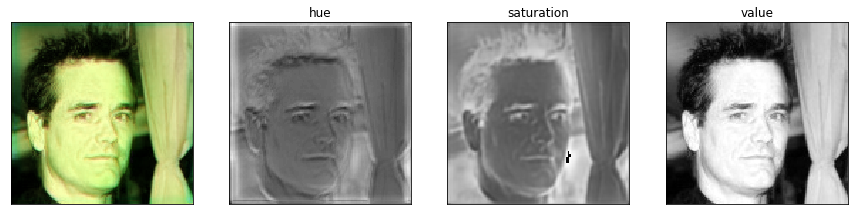

predy 1.3535657 230.70314 79.91667 (1, 128, 128, 2)
hue: 1.3535657 79.348915 38.062996
sat: 67.831154 230.70314 121.77034
predy uint8 1 230 79.41876220703125
hue uint8 1 79 37.56622314453125


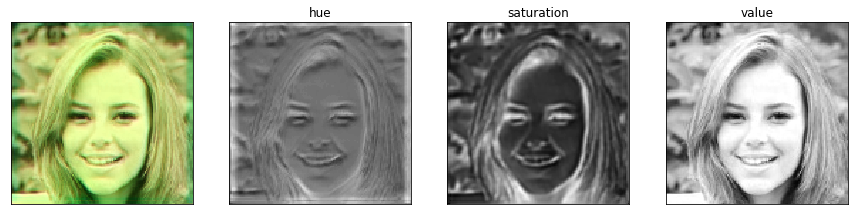

In [114]:
print('countEpochs',countEpochs)
predictions(10+trainSize)


In [ ]:
def nonMlBaseline():
    x = training_generator[33][0][0,...,0]
    y = np.dstack([params['mean'][...,0].astype('uint8'), params['mean'][...,1].astype('uint8'), x.astype('uint8')])
    #print(y.shape, params['mean'][...,0].min(), params['mean'][...,0].max(), x.dtype, x.min(), x.max())
    # plt.imshow(x - params['mean'][...,2])
    fig = plt.figure(figsize=(8,8))
    for i in range(1,4):
        fig.add_subplot(1,3,i)
        plt.title(['hue','saturation','value'][i-1])
        plt.imshow(params['mean'][...,i-1])
    plt.show()
    print("Input value with mean hue and mean saturation:")
    showHsv(y)
nonMlBaseline()

In [ ]:
print("testing custom Loss:")
x = Input(shape=(None,))
y = Input(shape=(None,))
loss_func = K.function([x, y], [customLoss(x, y)])
loss_func([[[[1,1], [1,16] ]], [[[1,1], [1,14]]] ])

In [ ]:
model.save(f'data/{NAME}.h5')

In [ ]:
print(training_generator[batch][0][0,...,0].shape)
print('sanity check - mean[...,2] is val mean:')
ttt =(training_generator[batch][0][6,...,0] - params['mean'][...,2]  ) / np.sqrt(params['var'][...,2])
plt.imshow(ttt) 
ttt.min(), ttt.max(), ttt.mean()

In [ ]:
print('mean hue, saturation, value:')
h,s,v = params['mean'][...,0], params['mean'][...,1], params['mean'][...,2]
showHsv(np.dstack([h,s,v]).astype('uint8'))
for i,c in enumerate([h,s,v]):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(c)

plt.show()


In [ ]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
batch=55
print('testing channel ranges:')
print(training_generator[batch][1][...,0].max(), training_generator[batch][1][...,0].min())
print(training_generator[batch][1].shape)
h = np.minimum(training_generator[batch][1][0,..., 0 ] + 0, 180).astype('uint8') 
s = np.minimum(training_generator[batch][1][0,..., 1 ] + 0, 255).astype('uint8')
v = training_generator[batch][0][0,...].astype('uint8')
y = np.dstack([h , s, v ] )
showHsv(y )
print(h.min(), h.max())
plt.imshow(h)

In [ ]:
x1w = model.get_weights()[0][:,:,0,:]
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()